In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d, interp2d
import sofi
import sofiism as si
from time import time
from scipy import signal
import pandas as pd
from gaussfitter_as import gaussfit
import cv2
import gaussfitter as gs
from scipy.optimize import curve_fit
import joblib
import control as ctr
import time

In [8]:

## Change trigger ID in later function
def upload_file(data_folder, filename):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)

    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    
    return(np.unique(val_addr, return_counts=True)[1])


def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    a=val_timestamps.shape[0]
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26

    return(val_time)
def histogram_creation(val_addr,val_time,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    a=val_time.shape[0]
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:
            if val_addr[i]<25 and val_addr[i+b]<25:
                hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
                hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    ok
    """

    a = len(val_addr)
    pixels = np.zeros((y_points,x_points))
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        #print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                    delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                    delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time,x,y):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)

def counts_binned(val_addr,val_timestamps,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    bin_time = int(bin_time * 1e5)
    max_time = max(val_timestamps)
    counts = np.zeros((int(np.ceil(max_time/bin_time)),23))

    for i  in range(len(val_addr)):
        if val_addr[i]<25:
            bin_number = int(np.floor((val_timestamps[i])/bin_time))
            counts[bin_number,val_addr[i]] += 1
           
    return(counts)

def G2_calc_scan(val_addr,val_time,points,x,y,correction,delay_range=200):
    
    hist = np.zeros((23,23,x,y,delay_range+1))
    for xa in range(x):
        for ya in range(y):
            print(xa,ya)
            if xa==x-1 and ya==0:
                continue
            if (xa%2==0 and ya == 30):
                temp_min = int(points[xa,ya])
                temp_max = int(points[xa+1,ya])
            elif (xa%2==1 and ya == 0):
                temp_min = int(points[xa,ya])
                temp_max = int(points[xa+1,ya])
            elif (xa%2==0):
                temp_min = int(points[xa,ya])
                temp_max = int(points[xa,ya+1])
            else:
                temp_min = int(points[xa,ya-1])
                temp_max = int(points[xa,ya])                

            if temp_min>temp_max:
                tttt = temp_min
                temp_min= temp_max
                temp_max = tttt
            temp_addr = val_addr[temp_min:temp_max]
            temp_time = val_time[temp_min:temp_max]
            counts_detec_a = np.unique(temp_addr, return_counts=True)[1]
            counts_detec_1 = np.concatenate((np.concatenate((counts_detec_a[:14],np.zeros(1))),counts_detec_a[14:]))                   

            for i in range(temp_addr.shape[0]-1):
                b=1    
                diff = temp_time[i+b]-temp_time[i]

                while diff<=delay_range/2 and diff>=0:
                    if temp_addr[i]<25 and temp_addr[i+b]<25:
                        hist[temp_addr[i],temp_addr[i+b],xa,ya,delay_range//2+diff]+=1
                        hist[temp_addr[i+b],temp_addr[i],xa,ya,delay_range//2-diff]+=1
                        b+=1
                        try:
                            diff = temp_time[i+b]-temp_time[i]
                        except:
                            break
                    else:
                        break
            corrected_hist = np.copy(hist[:,:,xa,ya,97:104])                   
            xx,yy = np.meshgrid(counts_detec_1,counts_detec_1)
            zz= xx+yy
            tempzz=np.multiply(zz[:23,:23],correction)
            print(hist.shape,counts_detec_1.shape,temp_max,temp_min)
            for t in range(18):
                corrected_hist[t,t+5,4:7]=hist[t,t+5,xa,ya,101:104]-counts_detec_1[t]*correction_extra[t]
                corrected_hist[t+5,t,0:3]=hist[t+5,t,xa,ya,97:100]-counts_detec_1[t]*np.flip(correction_extra[t])
            corrected_hist[:,:,3] = hist[:,:,xa,ya,100]-tempzz       
            hist[:,:,xa,ya,97:104] = corrected_hist[:,:,:]
    return(hist)


(correction,correction_extra,h)= joblib.load('correction_parameters_master.pkl')
vx=np.load('vx_06_07_2020.npy')
vy=np.load('vy_06_07_2020.npy')


In [9]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# dwell and bin times in ms
nanoSPAD_X= 20
nanoSPAD_Y= 20
dwell_time = 50
bin_time = 10
data_folder="./data/NANOspad/2021.06/"
data_file = "skylan_astro_test_20x20_dwell50.spad"
val_addr, val_timestamps  = upload_file(data_folder,filename)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
#counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
s = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)
np.save(data_folder+data_file.replace(".spad", ".txt"),s)

[[255 255 255 239]
 [118  35   0 200]
 [ 91  44   0 216]
 [ 24  60   0 128]
 [ 66  77   0 176]
 [155  91   0 128]
 [108 113   0 128]
 [ 22 209   0 152]]
line 0
line 1
line 2
line 3
line 4
line 5
line 6
line 7
line 8
line 9
line 10
line 11
line 12
line 13
line 14
line 15
line 16
line 17
line 18
line 19


In [21]:
#s=np.load('./data/NANOspad/2021.06/MAP2_AF488_test_20x20_dwell50_numpy.npy')

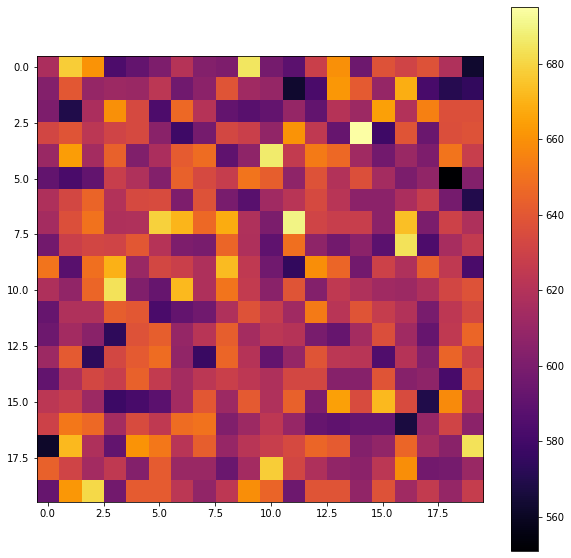

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(s.sum(axis=(0,3)))
plt.colorbar()

In [20]:
s.shape

(5, 20, 20, 23)

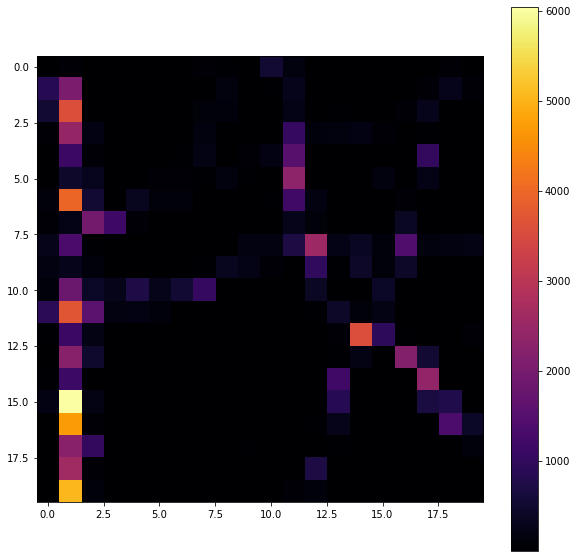

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(((s-s.mean(axis=0)[None,:,:,:])[:,:,:,None,:]*(s-s.mean(axis=0)[None,:,:,:])[:,:,:,:,None]).mean(axis=(0,3,4)))
plt.colorbar()

In [ ]:
plt.plot(val_time)

In [ ]:
val_addr = val_addr[1000000:]
val_timestamps = val_timestamps[1000000:]
nanoSPAD_Y= 29
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
s = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

In [534]:
data=np.loadtxt('75uW_5Mhz_AF+vecta_shield_v2.asc')

In [535]:
data.shape

(61440, 513)

In [536]:
61440/512

120.0

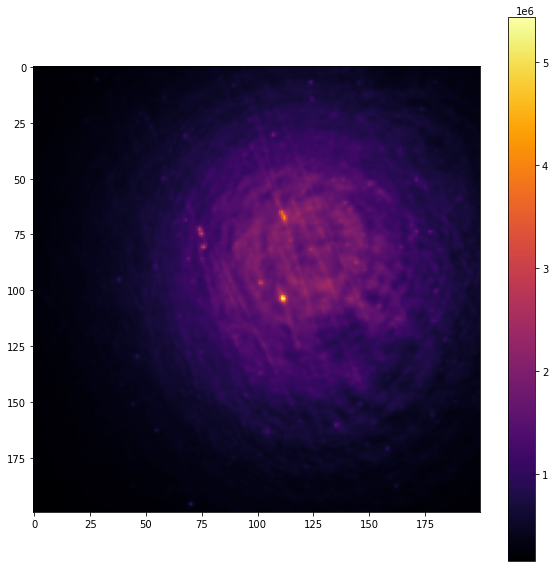

In [537]:
data=data.reshape((120,512,513))
plt.figure(figsize=(10,10))
plt.imshow((data.sum(axis=0)[200:400,100:300]))
plt.colorbar()

In [18]:
ac2=sofi.autocumulant_2(data,1)

In [13]:
np.shape((ac2))

(256, 257)

In [28]:
ac2=np.zeros((256,256))
for i in range(1,10):
    ac2+=np.array(sofi.autocumulant_2(data,i))[:,1:]

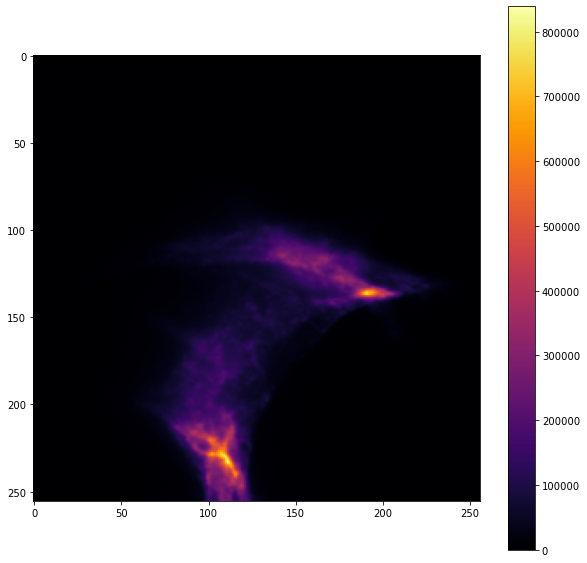

In [20]:
plt.figure(figsize=(10,10))
plt.imshow((np.abs(ac2)[:,1:]),vmin=0)
plt.colorbar()
plt.show()

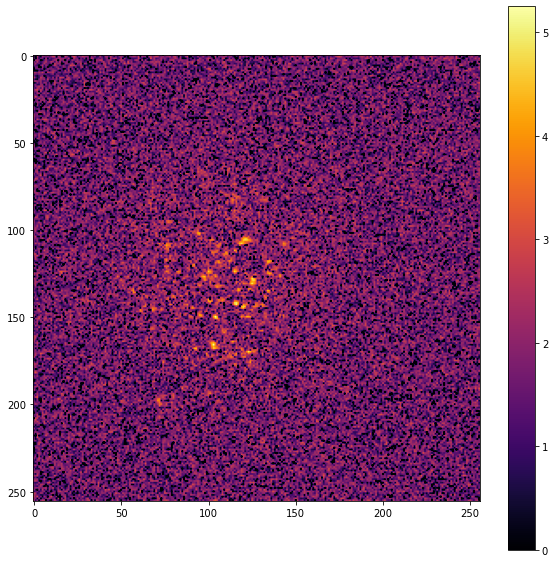

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(ac2)[:,1:]),vmin=0)
plt.colorbar()
plt.show()

In [ ]:
s=np.load('single_atto_647_18_8_AM_v6_5mhz_800nW_scan.npy')

In [15]:
s.shape

(5, 20, 20, 23)

In [573]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

In [574]:
xc2=si.get_xc2(scans[0,:,:,:,1:],vx[1:]*2/3,vy[1:]*2/3,0)
xc22=si.get_xc2(scans[0,:,:,:,1:],vx[1:]*2/3,vy[1:]*2/3,1)

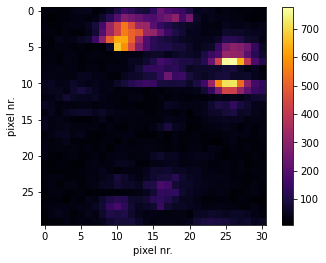

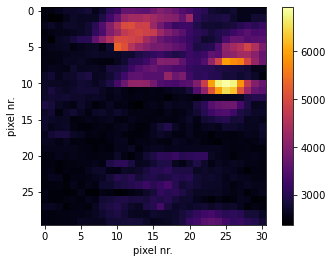

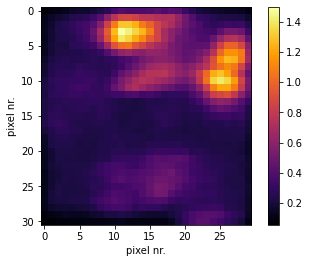

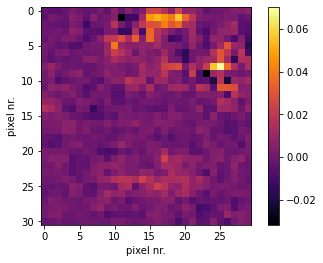

test


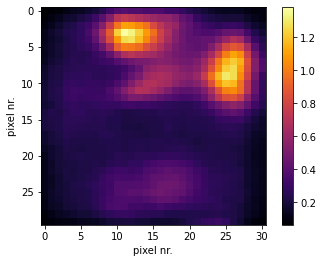

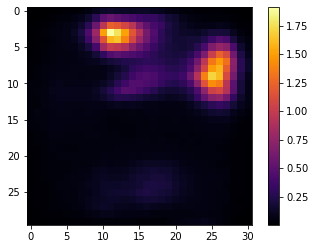

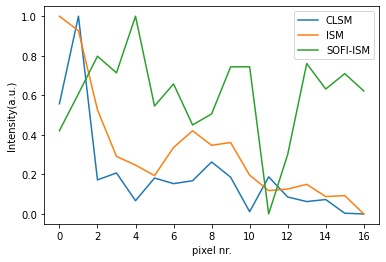

In [576]:
plt.imshow(scans.sum(axis=(0,1))[:,:,11])
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(scans.sum(axis=(0,1,4)))
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(xc2.T)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(xc22.T)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()

plt.show()
print('test')
plt.imshow(si.ac1_image(scans[:,:,:,:,1:],vx[1:],vy[1:]))
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(np.multiply(si.ac1_image(scans[:,:,:,:,1:],vx[1:],vy[1:]),si.ac1_image(scans[:,:,:,:,1:],vx[1:],vy[1:])))
plt.colorbar()
plt.show()
plt.plot((scans.sum(axis=(0,1,4))[3:20,7]-min(scans.sum(axis=(0,1,4))[3:20,7]))/max((scans.sum(axis=(0,1,4))[3:20,7]-min(scans.sum(axis=(0,1,4))[3:20,7]))),label ='CLSM')
plt.plot((si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]-min(si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]))/(max((si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]))-min(si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7])),label ='ISM')
plt.plot((xc22.T[3:20,7]-min(xc22.T[3:20,7]))/(max(xc22.T[3:20,7])-min(xc22.T[3:20,7])),label ='SOFI-ISM')
#plt.plot((xc2.T[3:20,6]-min(xc2.T[3:20,6]))/(max(xc2.T[3:20,6])-min(xc2.T[14,3:20])),label ='SOFIISM')
plt.xlabel('pixel nr.')
plt.ylabel('Intensity(a.u.)')
plt.legend()
plt.show()

In [526]:
cross1a= (scans.sum(axis=(0,1,4))[3:20,7]-min(scans.sum(axis=(0,1,4))[3:20,7]))/max((scans.sum(axis=(0,1,4))[3:20,7]-min(scans.sum(axis=(0,1,4))[3:20,7])))
cross2a = (si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]-min(si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]))/(max((si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]))-min(si.ac1_image(scans,vx*2/3,vy*2/3)[3:20,7]))
cross3a = (xc22.T[3:20,7]-min(xc22.T[3:20,7]))/(max(xc22.T[3:20,7])-min(xc22.T[3:20,7]))
joblib.dump((cross1a,cross2a,cross3a),'tofit1.pkl')

['tofit1.pkl']

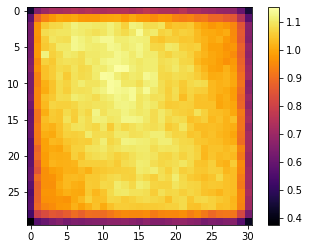

In [80]:
plt.imshow(si.ac1_image(scans[:,:,:,:,1:],0.5*vy[1:],0.5*vx[1:]))
plt.colorbar()

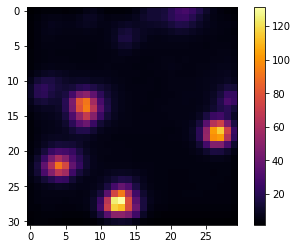

In [538]:
plt.imshow(xc2.T)
plt.colorbar()

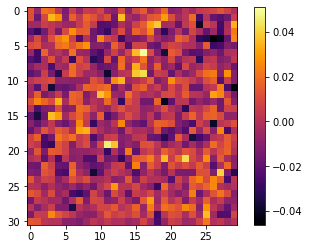

In [81]:
plt.imshow(si.get_xc2(si.rebin(scans,1)[0,:,:,:,1:],0.5*vx[1:],0.5*vy[1:],1).T)
plt.colorbar()

In [52]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)
xc20=si.get_xc2(scans[0,:,:,:,:],vx,vy,0)

0


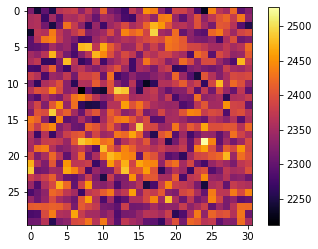

1


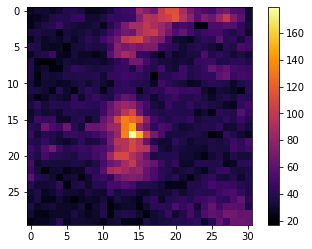

2


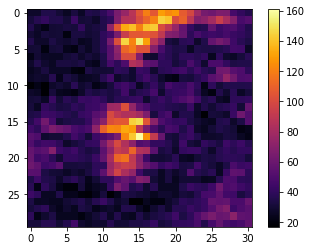

3


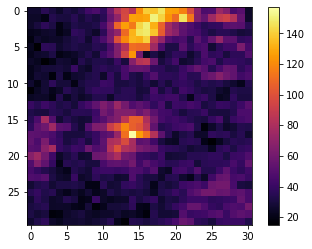

4


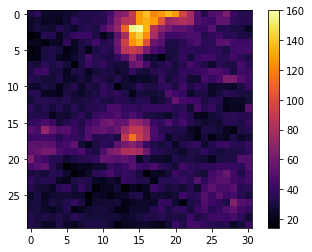

5


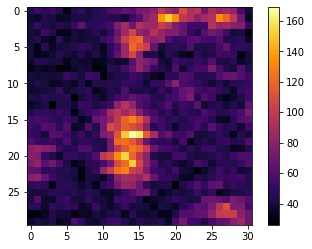

6


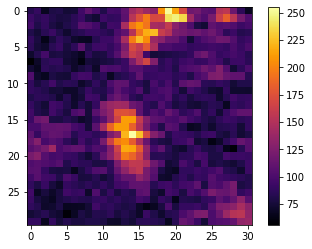

7


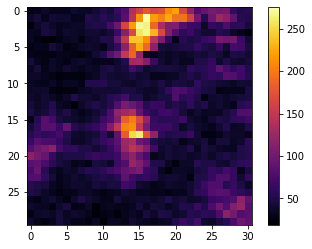

8


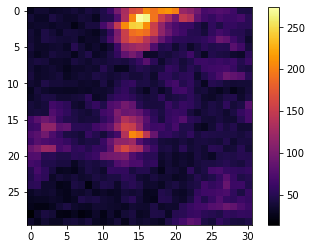

9


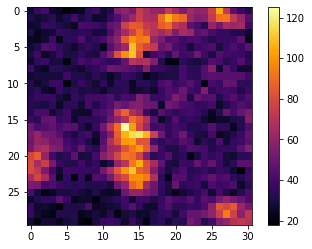

10


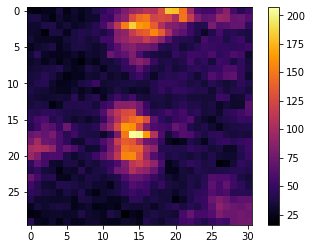

11


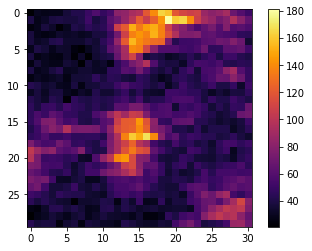

12


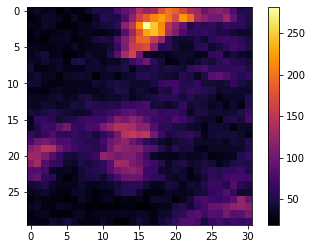

13


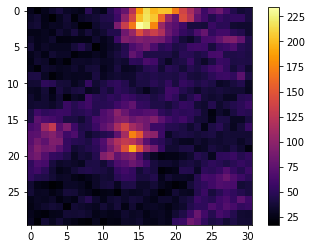

14


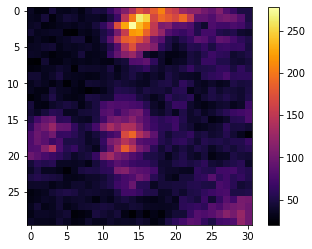

15


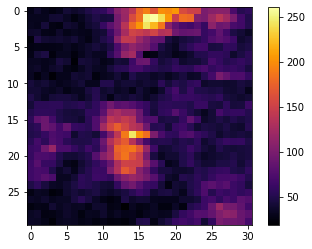

16


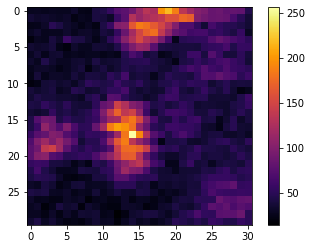

17


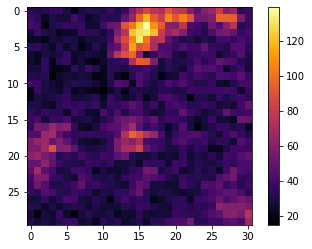

18


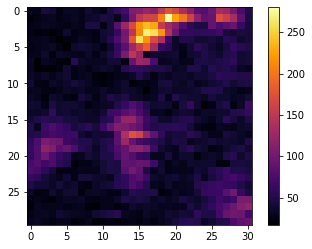

19


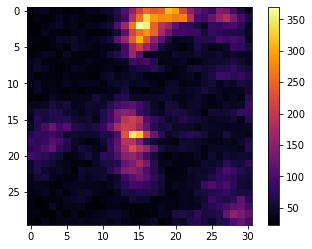

20


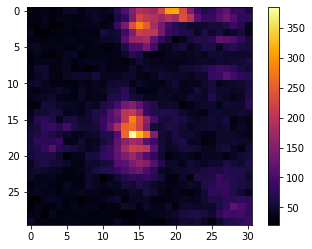

21


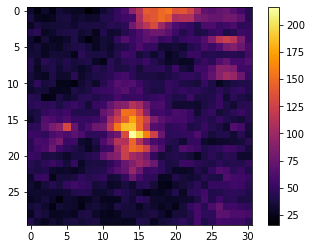

22


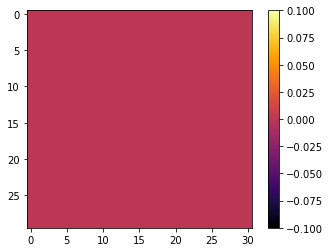

23


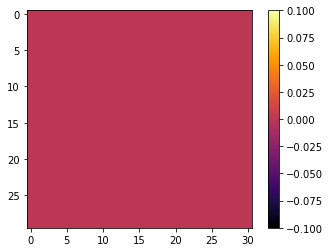

24


IndexError: index 24 is out of bounds for axis 4 with size 24

In [495]:
for i in range(scans.shape[1]):
    print(i)
    plt.imshow(scans[0,:,:,:,i].sum(axis=0))
    plt.colorbar()
    plt.show()

In [47]:
np.max(scans)

13.0

1.6927812339409507


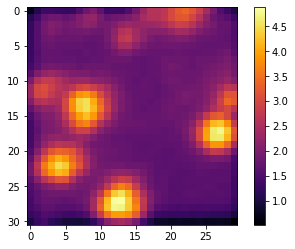

-0.05998452657873774


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


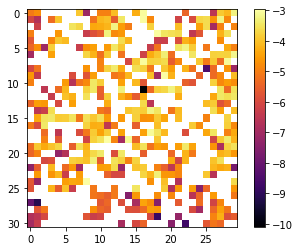

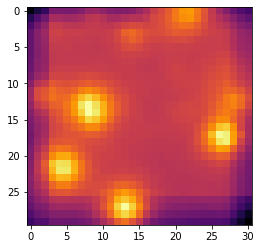

In [539]:
plt.imshow(np.log(xc2.T))
plt.colorbar()
print(np.min(xc2))
plt.show()
plt.imshow(np.log(xc20.T))
plt.colorbar()
print(np.min(xc20))
plt.show()
ac1=si.ac1_image(scans,vx,vy)
plt.imshow(np.log(ac1))

In [ ]:
#IMAGE v2 

In [491]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

In [492]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx*2/3,vy*2/3,1)
xc20=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)

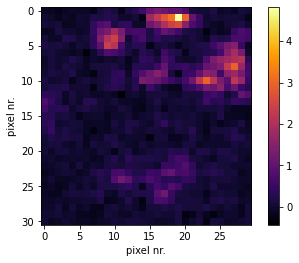

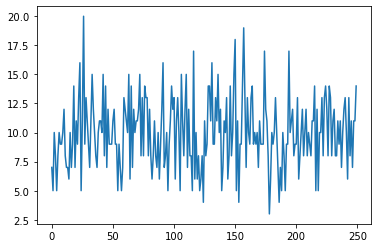

In [580]:
scans1a=si.rebin(scans, u=10)
xc21=si.get_xc2(scans1a[0,:250,:,:,1:],vx[1:]*2/3,vy[1:]*2/3,1)
plt.imshow(xc21.T)
plt.colorbar()
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.show()
plt.plot(np.nansum(scans1a[0,:,17,12],axis=1))

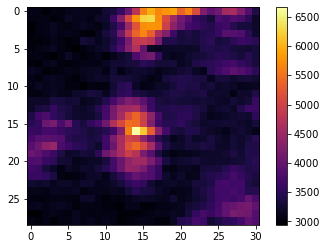

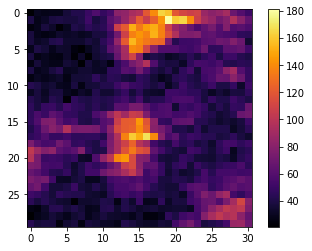

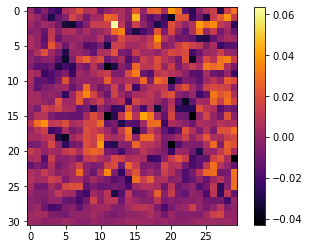

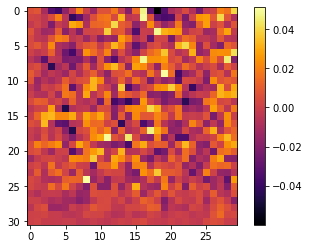

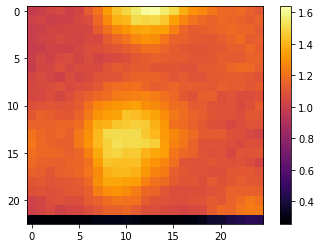

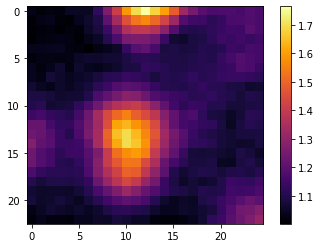

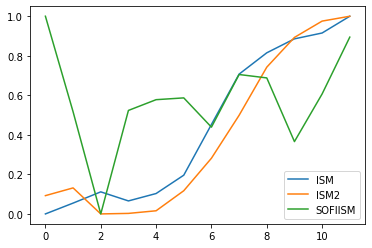

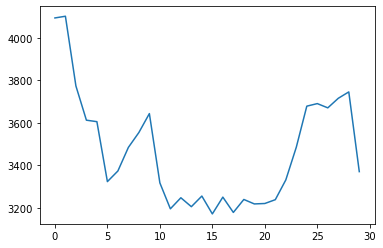

In [503]:
plt.imshow(scans[:,:,1:].sum(axis=(0,1,4)))
plt.colorbar()
plt.show()
plt.imshow(scans.sum(axis=(0,1))[:,:,11])
plt.colorbar()
plt.show()
plt.imshow(xc2.T)
plt.colorbar()
plt.show()
plt.imshow(xc20.T)
plt.colorbar()
plt.show()

plt.imshow(si.ac1_image(scans[:,:,1:],vx,vy)[3:-3,3:-3])
plt.colorbar()
plt.show()
plt.imshow(si.ac1_image(scans[:,:,1:],0.7*vx,0.7*vy)[3:-3,3:-3])
plt.colorbar()
plt.show()
#plt.plot((scans.sum(axis=(0,1,4))[5:20,8]-min(scans.sum(axis=(0,1,4))[14]))/(max((scans.sum(axis=(0,1,4))[5:20,8]))-min(scans.sum(axis=(0,1,4))[5:20,8])),label ='0')
#plt.plot((scans.sum(axis=(0,1))[14,:15,11]-min(scans.sum(axis=(0,1))[5:20,8,11]))/(max((scans.sum(axis=(0,1))[5:20,8,11]))-min((scans.sum(axis=(0,1))[5:20,8,11]))),label ='1')
plt.plot((si.ac1_image(scans,vx,vy)[14,3:15]-min(si.ac1_image(scans,vx,vy)[14,3:15]))/(max((si.ac1_image(scans,vx,vy)[14,3:15]))-min(si.ac1_image(scans,vx,vy)[14,3:15])),label ='ISM')
plt.plot((si.ac1_image(scans,vx*2/3,vy*2/3)[14,3:15]-min(si.ac1_image(scans,vx*2/3,vy*2/3)[14,3:15]))/(max((si.ac1_image(scans,vx*2/3,vy*2/3)[14,3:15]))-min(si.ac1_image(scans,vx*2/3,vy*2/3)[14,3:15])),label ='ISM2')
plt.plot((xc20.T[14,3:15]-min(xc20.T[14,3:15]))/(max(xc20.T[14,3:15])-min(xc20.T[14,3:15])),label ='SOFIISM')
plt.legend()
plt.show()
plt.plot(scans.sum(axis=(0,1,4))[:,25])

0.0


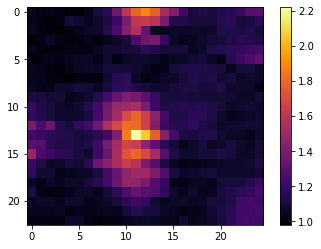

0.1


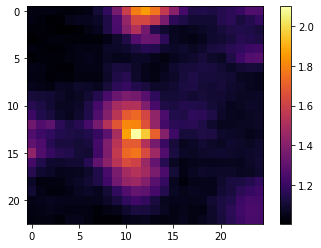

0.2


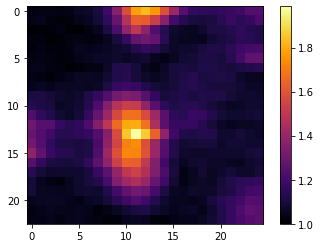

0.30000000000000004


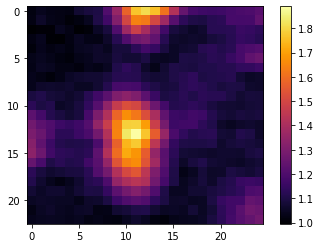

0.4


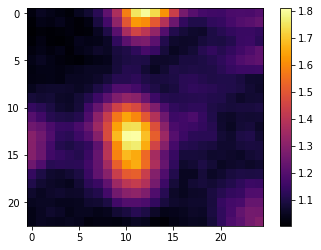

0.5


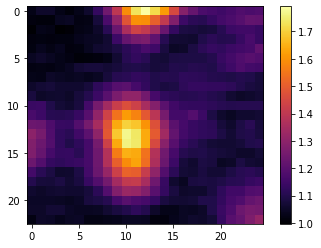

0.6000000000000001


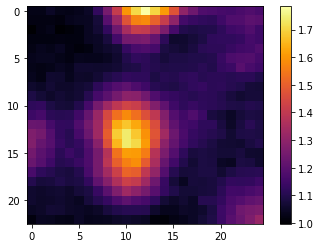

0.7000000000000001


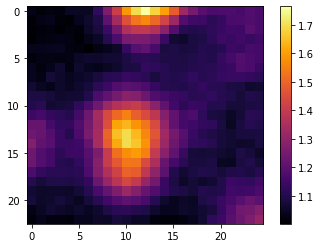

0.8


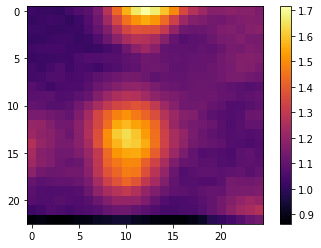

0.9


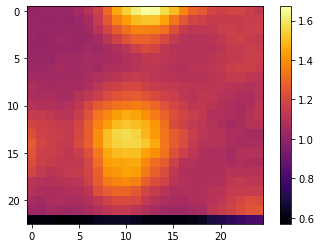

1.0


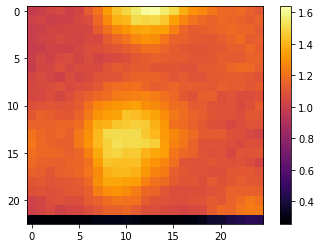

In [504]:
b = np.arange(0,1.1,0.1)
for a in b:
    print(a)
    plt.imshow(si.ac1_image(scans[:,:,1:],a*vx,a*vy)[3:-3,3:-3])
    plt.colorbar()
    plt.show()                     

In [ ]:
#IMAGE v3

In [417]:
scansb=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scansb[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)
scansb.shape

(1, 3000, 30, 31, 24)

In [541]:
xc2=si.get_xc2(scansb[0,:2500,:,:,1:],vx[1:]*1,vy[1:]*1,1)
xc22=si.get_xc2(scansb[0,:2500,:,:,1:],1*vx[1:],1*vy[1:],0)


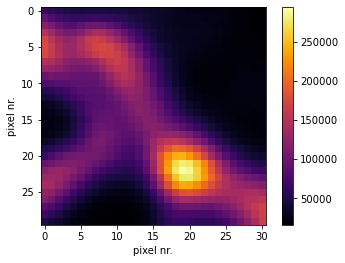

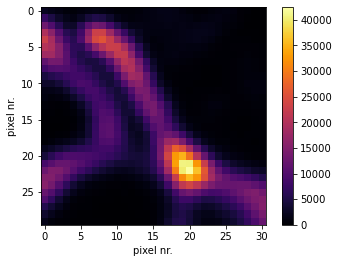

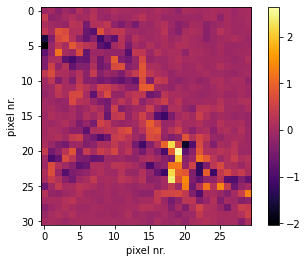

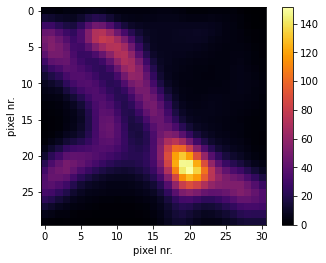

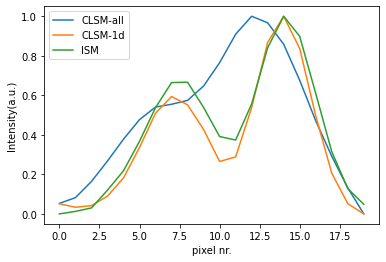

In [545]:
plt.imshow(scansb.sum(axis=(0,1,4)))
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(scansb.sum(axis=(0,1))[:,:,11] - np.amin(scansb.sum(axis=(0,1))[:,:,11]))
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(xc2.T)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()

plt.imshow(si.ac1_image(scansb,vx,vy)- np.amin(si.ac1_image(scansb,vx,vy)))
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()

plt.show()
plt.plot((scansb.sum(axis=(0,1,4))[12,:20]-min(scansb.sum(axis=(0,1,4))[12,:20]))/(max(scansb.sum(axis=(0,1,4))[12,:20])-min(scansb.sum(axis=(0,1,4))[12,:20])),label ='CLSM-all')
plt.plot((scansb.sum(axis=(0,1))[12,:20,11]-min(scansb.sum(axis=(0,1))[12,:20,11]))/(max(scansb.sum(axis=(0,1))[12,:20,11])-min(scansb.sum(axis=(0,1))[12,:20,11])),label ='CLSM-1d')
plt.plot((si.ac1_image(scansb,vx,vy)[12,:20]-min(si.ac1_image(scansb,vx,vy)[12,:20]))/(max(si.ac1_image(scansb,vx,vy)[12,:20])-min(si.ac1_image(scansb,vx,vy)[12,:20])),label ='ISM')
plt.xlabel('pixel nr.')
plt.ylabel('Intensity(a.u.)')
plt.legend()
plt.show()


In [435]:
cross1 =(scansb.sum(axis=(0,1,4))[12,:20]-min(scansb.sum(axis=(0,1,4))[12,:20]))/(max(scansb.sum(axis=(0,1,4))[12,:20])-min(scansb.sum(axis=(0,1,4))[12,:20]))
cross2 =(scansb.sum(axis=(0,1))[12,:20,11]-min(scansb.sum(axis=(0,1))[12,:20,11]))/(max(scansb.sum(axis=(0,1))[12,:20,11])-min(scansb.sum(axis=(0,1))[12,:20,11]))
cross3 = ((si.ac1_image(scansb,vx,vy)[12,:20]-min(si.ac1_image(scansb,vx,vy)[12,:20]))/(max(si.ac1_image(scansb,vx,vy)[12,:20])-min(si.ac1_image(scansb,vx,vy)[12,:20])))
joblib.dump((cross1,cross2,cross3),'tofit.pkl')   

['tofit.pkl']

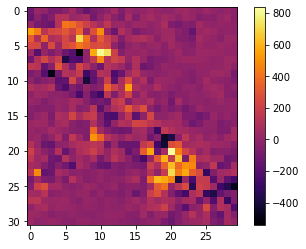

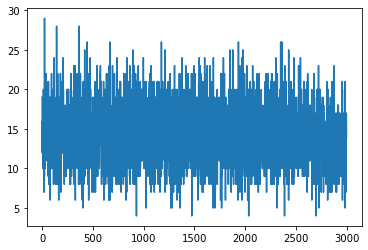

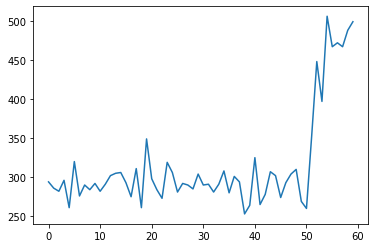

In [431]:
scans1=si.rebin(scansb, u=50)
#xc21=si.get_xc2(scans1[0,:50,:,:,1:],vx[1:]*1,vy[1:]*1,1)
plt.imshow(xc21.T)
plt.colorbar()
plt.show()
plt.plot(scansb[0,:,22,20,11])
plt.show()
plt.plot(scans1[0,:,22,17,11])

In [240]:
scans1=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],15))
a =0
vx1 = np.zeros(13)
vy1 = np.zeros(13)
for i in range(17):
    if i not in (4,8,13,14):
        scans1[0,:,:,:,a]=s[:,:,:,i]
        vx1[a]=vx[i]
        vy1[a]=vy[i]
        a+=1
        

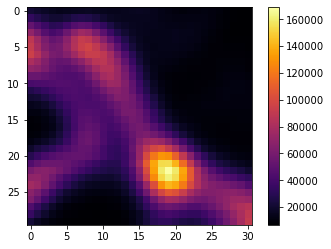

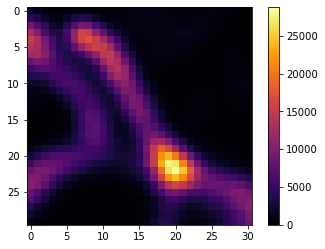

269.3636363636364 168.02649830378363
36.21784108664773 4.773663176937908
28748.0 812.2872900390626


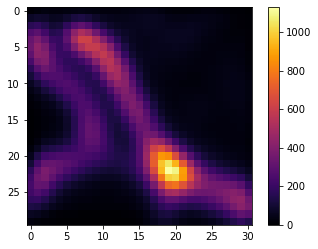

0
91.83459555577205
1
133.98173904136152
2
149.0580863906671
3
127.83338935913086
4
108.42953613745975
5
157.51240223261078
6
167.3697684298892
7
92.81615291961874
8
118.1783521041616
9
171.09206161057426
10
136.54696021129539
11
121.98197358294259
12
96.93569912753674
170.16016001365824


In [273]:
plt.imshow(scans1.sum(axis=(0,1,4)))
plt.colorbar()
plt.show()
plt.imshow(scans1.sum(axis=(0,1))[:,:,9] - np.amin(scans1.sum(axis=(0,1))[:,:,9]))
plt.colorbar()
plt.show()

"""
for a in np.arange(0,2,0.1):
    print(a)
    plt.imshow(si.ac1_image(scans1,vx1*a,vy1*a)- np.amin(si.ac1_image(scans1,vx1*a,vy1*a)))
    plt.colorbar()
    plt.show()
"""
print(np.mean(scans1.sum(axis=(0,1))[5:15,20:,9] - np.amin(scans1.sum(axis=(0,1))[5:15,20:,9])),np.std(scans1.sum(axis=(0,1))[5:15,20:,9] - np.amin(scans1.sum(axis=(0,1))[5:15,20:,9])))
b=0.60
print(np.mean((si.ac1_image(scans1,vx*b,vy*b)- np.amin(si.ac1_image(scans1,vx*b,vy*b)))[5:15,20:]),np.std((si.ac1_image(scans1,vx*b,vy*b)- np.amin(si.ac1_image(scans1,vx*b,vy*b)))[5:15,20:]))
print(np.max(scans1.sum(axis=(0,1))[:,:,9] - np.amin(scans1.sum(axis=(0,1))[:,:,9])),np.max(si.ac1_image(scans1,vx*b,vy*b)- np.amin(si.ac1_image(scans1,vx*b,vy*b))))
a=b
plt.imshow(si.ac1_image(scans1,vx1*a,vy1*a)- np.amin(si.ac1_image(scans1,vx1*a,vy1*a)))

plt.colorbar()
plt.show()
test =[] 
for i in range(13):
    print(i)
    print(np.max(scans1.sum(axis=(0,1))[:,:,i] - np.amin(scans1.sum(axis=(0,1))[:,:,i]))/np.std(scans1.sum(axis=(0,1))[5:15,20:,i] - np.amin(scans1.sum(axis=(0,1))[5:15,20:,i])))
    test += [np.max(scans1.sum(axis=(0,1))[:,:,i] - np.amin(scans1.sum(axis=(0,1))[:,:,i]))/np.std(scans1.sum(axis=(0,1))[5:15,20:,i] - np.amin(scans1.sum(axis=(0,1))[5:15,20:,i]))]
print(np.max(si.ac1_image(scans1,vx*b,vy*b)- np.amin(si.ac1_image(scans1,vx*b,vy*b)))/np.std((si.ac1_image(scans1,vx*b,vy*b)- np.amin(si.ac1_image(scans1,vx*b,vy*b)))[5:15,20:]))

In [548]:
#SNR

scans_binned=[None]*10
ISM_binned=[None]*10
CLSM_single1 = [None]*10
for i in range(10):
    print (i)
    scans_binned[i]=scansb[:,i*20:(i+1)*20]
    print(scans_binned[i].shape)
    ISM_binned[i] = si.ac1_image(scans_binned[i][:,:,:,:,1:],vx[1:]*a,vy[:]*a)
    CLSM_single[i] = scans_binned[i].sum(axis=(0,1,4))
    CLSM_single1[i] = scans_binned[i].sum(axis=(0,1))[:,:,11]

0
(1, 20, 30, 31, 24)
1
(1, 20, 30, 31, 24)
2
(1, 20, 30, 31, 24)
3
(1, 20, 30, 31, 24)
4
(1, 20, 30, 31, 24)
5
(1, 20, 30, 31, 24)
6
(1, 20, 30, 31, 24)
7
(1, 20, 30, 31, 24)
8
(1, 20, 30, 31, 24)
9
(1, 20, 30, 31, 24)


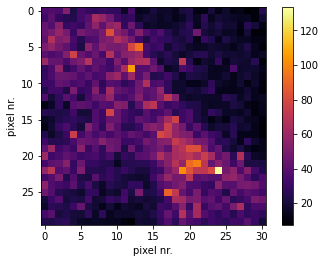

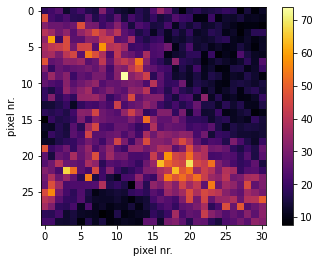

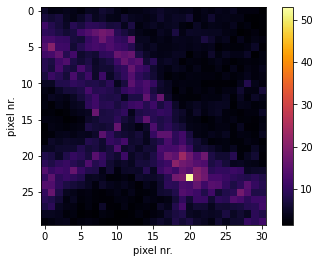

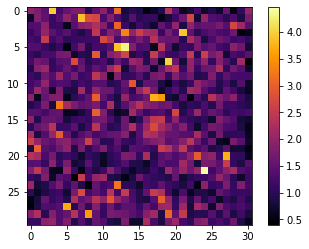

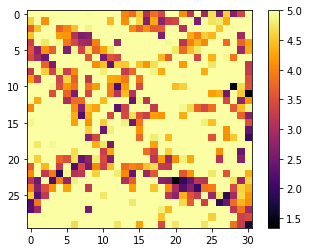

In [549]:

SNR_ISM = np.mean(ISM_binned,axis=0)/np.std(ISM_binned,axis=0)
SNR_CLSM  = np.mean(CLSM_single,axis=0)/np.std(CLSM_single,axis=0)
SNR_CLSM1  = np.mean(CLSM_single1,axis=0)/np.std(CLSM_single1,axis=0)
plt.imshow(SNR_ISM)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(SNR_CLSM)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(SNR_CLSM1)
plt.xlabel('pixel nr.')
plt.ylabel('pixel nr.')
plt.colorbar()
plt.show()
plt.imshow(SNR_ISM/SNR_CLSM)
plt.colorbar()
plt.show()
plt.imshow(SNR_ISM/SNR_CLSM1,vmax=5)
plt.colorbar()
plt.show()

In [319]:
print(np.mean(SNR_ISM[5:10,5:10]/SNR_CLSM[5:10,5:10]))
print(np.mean(SNR_ISM[5:10,5:10]/SNR_CLSM1[5:10,5:10]))

1.4207347481711254
4.758168138715965


In [45]:

start=time.time()

xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1).T
print(time.time()-start)
#for i in range(3):
#    print(i)
#    xc2+=si.get_xc2(scans[0,:,:,:,:],vx,vy,2+i).T

23.450999975204468


-3.1182248358491704


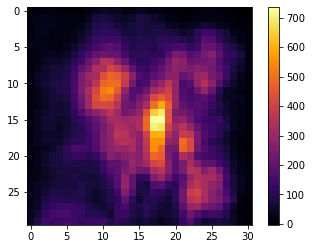

In [161]:
plt.imshow(xc2)
plt.colorbar()
print(np.min(xc2))

In [134]:
g2 = G2_calc_scan(val_addr,val_time,points,30,31,correction,delay_range=200)

0 0
(23, 23, 30, 31, 201) (25,) 127389 107105
0 1
(23, 23, 30, 31, 201) (24,) 148217 127389
0 2
(23, 23, 30, 31, 201) (24,) 171183 148217
0 3
(23, 23, 30, 31, 201) (24,) 193326 171183
0 4
(23, 23, 30, 31, 201) (24,) 215210 193326
0 5
(23, 23, 30, 31, 201) (24,) 236921 215210
0 6
(23, 23, 30, 31, 201) (24,) 259058 236921
0 7
(23, 23, 30, 31, 201) (24,) 281074 259058
0 8
(23, 23, 30, 31, 201) (24,) 304564 281074
0 9
(23, 23, 30, 31, 201) (24,) 329663 304564
0 10
(23, 23, 30, 31, 201) (24,) 354073 329663
0 11
(23, 23, 30, 31, 201) (24,) 378037 354073
0 12
(23, 23, 30, 31, 201) (24,) 400146 378037
0 13
(23, 23, 30, 31, 201) (24,) 423843 400146
0 14
(23, 23, 30, 31, 201) (24,) 450982 423843
0 15
(23, 23, 30, 31, 201) (24,) 479102 450982
0 16
(23, 23, 30, 31, 201) (24,) 510865 479102
0 17
(23, 23, 30, 31, 201) (24,) 550531 510865
0 18
(23, 23, 30, 31, 201) (24,) 601965 550531
0 19
(23, 23, 30, 31, 201) (24,) 657491 601965
0 20
(23, 23, 30, 31, 201) (24,) 713083 657491
0 21
(23, 23, 30, 31, 2

(23, 23, 30, 31, 201) (24,) 4825121 4800893
5 17
(23, 23, 30, 31, 201) (24,) 4800893 4776403
5 18
(23, 23, 30, 31, 201) (24,) 4776403 4752833
5 19
(23, 23, 30, 31, 201) (24,) 4752833 4728136
5 20
(23, 23, 30, 31, 201) (24,) 4728136 4701782
5 21
(23, 23, 30, 31, 201) (24,) 4701782 4678554
5 22
(23, 23, 30, 31, 201) (24,) 4678554 4654217
5 23
(23, 23, 30, 31, 201) (24,) 4654217 4631248
5 24
(23, 23, 30, 31, 201) (24,) 4631248 4607659
5 25
(23, 23, 30, 31, 201) (24,) 4607659 4585094
5 26
(23, 23, 30, 31, 201) (24,) 4585094 4561955
5 27
(23, 23, 30, 31, 201) (24,) 4561955 4539675
5 28
(23, 23, 30, 31, 201) (24,) 4539675 4517314
5 29
(23, 23, 30, 31, 201) (24,) 4517314 4493502
5 30
(23, 23, 30, 31, 201) (24,) 4493502 4467966
6 0
(23, 23, 30, 31, 201) (24,) 5198498 5177386
6 1
(23, 23, 30, 31, 201) (24,) 5220100 5198498
6 2
(23, 23, 30, 31, 201) (24,) 5241444 5220100
6 3
(23, 23, 30, 31, 201) (24,) 5262607 5241444
6 4
(23, 23, 30, 31, 201) (24,) 5285061 5262607
6 5
(23, 23, 30, 31, 201) (24,

(23, 23, 30, 31, 201) (24,) 8854968 8823109
11 0
(23, 23, 30, 31, 201) (24,) 9709183 9683152
11 1
(23, 23, 30, 31, 201) (24,) 9683152 9652571
11 2
(23, 23, 30, 31, 201) (24,) 9652571 9626425
11 3
(23, 23, 30, 31, 201) (24,) 9626425 9595815
11 4
(23, 23, 30, 31, 201) (24,) 9595815 9566874
11 5
(23, 23, 30, 31, 201) (24,) 9566874 9537371
11 6
(23, 23, 30, 31, 201) (24,) 9537371 9504422
11 7
(23, 23, 30, 31, 201) (24,) 9504422 9474004
11 8
(23, 23, 30, 31, 201) (24,) 9474004 9433286
11 9
(23, 23, 30, 31, 201) (24,) 9433286 9394518
11 10
(23, 23, 30, 31, 201) (24,) 9394518 9366323
11 11
(23, 23, 30, 31, 201) (24,) 9366323 9337275
11 12
(23, 23, 30, 31, 201) (24,) 9337275 9309618
11 13
(23, 23, 30, 31, 201) (24,) 9309618 9284697
11 14
(23, 23, 30, 31, 201) (24,) 9284697 9262824
11 15
(23, 23, 30, 31, 201) (24,) 9262824 9240834
11 16
(23, 23, 30, 31, 201) (24,) 9240834 9219662
11 17
(23, 23, 30, 31, 201) (24,) 9219662 9198792
11 18
(23, 23, 30, 31, 201) (24,) 9198792 9177418
11 19
(23, 23, 3

(23, 23, 30, 31, 201) (24,) 13540449 13503068
16 7
(23, 23, 30, 31, 201) (24,) 13579189 13540449
16 8
(23, 23, 30, 31, 201) (24,) 13618964 13579189
16 9
(23, 23, 30, 31, 201) (24,) 13648610 13618964
16 10
(23, 23, 30, 31, 201) (24,) 13676996 13648610
16 11
(23, 23, 30, 31, 201) (24,) 13703738 13676996
16 12
(23, 23, 30, 31, 201) (24,) 13730606 13703738
16 13
(23, 23, 30, 31, 201) (24,) 13756465 13730606
16 14
(23, 23, 30, 31, 201) (24,) 13780112 13756465
16 15
(23, 23, 30, 31, 201) (24,) 13802313 13780112
16 16
(23, 23, 30, 31, 201) (24,) 13823501 13802313
16 17
(23, 23, 30, 31, 201) (24,) 13844328 13823501
16 18
(23, 23, 30, 31, 201) (24,) 13865596 13844328
16 19
(23, 23, 30, 31, 201) (24,) 13887260 13865596
16 20
(23, 23, 30, 31, 201) (24,) 13908753 13887260
16 21
(23, 23, 30, 31, 201) (24,) 13931327 13908753
16 22
(23, 23, 30, 31, 201) (24,) 13953937 13931327
16 23
(23, 23, 30, 31, 201) (24,) 13977384 13953937
16 24
(23, 23, 30, 31, 201) (24,) 14002472 13977384
16 25
(23, 23, 30, 31

(23, 23, 30, 31, 201) (24,) 18102753 18079377
21 13
(23, 23, 30, 31, 201) (24,) 18079377 18057866
21 14
(23, 23, 30, 31, 201) (24,) 18057866 18036684
21 15
(23, 23, 30, 31, 201) (24,) 18036684 18015929
21 16
(23, 23, 30, 31, 201) (24,) 18015929 17994619
21 17
(23, 23, 30, 31, 201) (24,) 17994619 17973388
21 18
(23, 23, 30, 31, 201) (24,) 17973388 17952786
21 19
(23, 23, 30, 31, 201) (24,) 17952786 17933184
21 20
(23, 23, 30, 31, 201) (24,) 17933184 17913089
21 21
(23, 23, 30, 31, 201) (24,) 17913089 17892615
21 22
(23, 23, 30, 31, 201) (24,) 17892615 17871851
21 23
(23, 23, 30, 31, 201) (24,) 17871851 17851421
21 24
(23, 23, 30, 31, 201) (24,) 17851421 17830639
21 25
(23, 23, 30, 31, 201) (24,) 17830639 17808848
21 26
(23, 23, 30, 31, 201) (24,) 17808848 17781273
21 27
(23, 23, 30, 31, 201) (24,) 17781273 17756523
21 28
(23, 23, 30, 31, 201) (24,) 17756523 17731967
21 29
(23, 23, 30, 31, 201) (24,) 17731967 17707258
21 30
(23, 23, 30, 31, 201) (24,) 17707258 17683040
22 0
(23, 23, 30, 

(23, 23, 30, 31, 201) (24,) 22242029 22219373
26 19
(23, 23, 30, 31, 201) (24,) 22263706 22242029
26 20
(23, 23, 30, 31, 201) (24,) 22283104 22263706
26 21
(23, 23, 30, 31, 201) (24,) 22302827 22283104
26 22
(23, 23, 30, 31, 201) (24,) 22321961 22302827
26 23
(23, 23, 30, 31, 201) (24,) 22341662 22321961
26 24
(23, 23, 30, 31, 201) (24,) 22360972 22341662
26 25
(23, 23, 30, 31, 201) (24,) 22380076 22360972
26 26
(23, 23, 30, 31, 201) (24,) 22399088 22380076
26 27
(23, 23, 30, 31, 201) (24,) 22418033 22399088
26 28
(23, 23, 30, 31, 201) (24,) 22437235 22418033
26 29
(23, 23, 30, 31, 201) (24,) 22456185 22437235
26 30
(23, 23, 30, 31, 201) (24,) 22475211 22456185
27 0
(23, 23, 30, 31, 201) (24,) 23266792 23241411
27 1
(23, 23, 30, 31, 201) (24,) 23241411 23217080
27 2
(23, 23, 30, 31, 201) (24,) 23217080 23194412
27 3
(23, 23, 30, 31, 201) (24,) 23194412 23171790
27 4
(23, 23, 30, 31, 201) (24,) 23171790 23147753
27 5
(23, 23, 30, 31, 201) (24,) 23147753 23124250
27 6
(23, 23, 30, 31, 20

In [146]:
g2_sum =np.nansum(g2[1:,1:],axis=(0,1))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


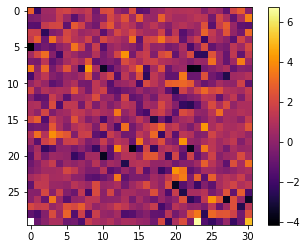

In [147]:
plt.imshow(g2_sum[:,:,100]/np.amax(g2_sum[:,:,110:],axis=2))
plt.colorbar()

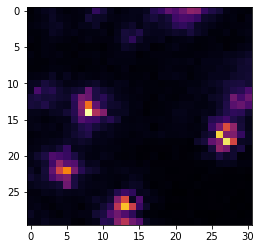

In [166]:
    plt.imshow(scans[0,:,:,:,11].sum(axis=0))

In [409]:
 def get_xc2_debug(film, vx, vy, lag1=0):
    det = film.shape[3] - 2  # number of detectors
    w, h = film.shape[2], film.shape[1]  # shape im img
    N = film.shape[0]  # Number of frames
    im_t = np.zeros((h, w))  # our image (in future)

    mask = np.ones((det, det), dtype=bool)
 
    zeros_to_concat = np.zeros(
        (det, det, 1, 2), dtype=np.float64)

    if lag1 == 0:

        for x in range(h):  # loop over x positions
            for y in range(w):  # loop over y positions
                #print(f'Calculation for x={x} and y={y}')
                #t1 = time.time()
                data = film[:, x, y, :-2]
                data = data - np.amin(data, axis=0)
                d = data[:, :, np.newaxis] * data[:, np.newaxis, :] 
                d = d.mean(axis=0)
                d = d[mask]
                d = d.reshape(det, det)

                translation_matrix = si.get_transition_matrix_2(
                    vx, vy, x, y, mask)
                im_t = im_t + si.get_image_2(d, translation_matrix, w, h)
                #t2 = time.time()
                #print(f'took {t2-t1} seconds\n')

    if lag1!= 0:
        for x in range(h):  # loop over x positions
            for y in range(w):  # loop over y positions
               # print(
                #    f'Calculation for x={x}, y={y}, lag1={lag1} and lag2={lag2}')
                data = film[:, x, y, :-2]
                data = data - np.amin(data, axis=0)

                #t1_lag = time.time()
                d = data[lag1:, :, np.newaxis] * data[:N - lag1, np.newaxis, :]
                  
                d = d.mean(axis=0)
                d = d[mask]
                d = d.reshape(det, det )
                if np.amin(d)<-10:
                    print(x,y)
                    plt.imshow(d)
                    plt.show()
                    input()
                translation_matrix = si.get_transition_matrix_2(vx, vy, x, y, mask)
                im_t = im_t + \
                    si.get_image_2(d, translation_matrix, w, h)
               # t2_lag = time.time()
                #print(f'took {t2_lag - t1_lag} seconds\n')
    return im_t  